# Limiting Spread of COVID Misinformation via Twitter
### Author: Donald Stephens (dsteph@stanford.edu)
### Date: Q2-2022

<hr/>

### Packages and Installation

In [1]:
# pip install -U skorch

<hr/>

### References and dependencies

In [141]:
import os
import pandas as pd
import numpy as np
from enum import Enum, unique

from data_utils import *
from models.LogisticRegression.log_reg_model import *
from models.XGBoost.xgboost_model import *
from models.RandomForest.random_forest_model import *
from models.CNN.cnn_model import *
from models.BiLSTM.bi_lstm_rnn_model import *
from models.BERT.bert_model import *
from models.RoBERTa.rob_bert_model import *

import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

import warnings
from sklearn.exceptions import ConvergenceWarning
#from sklearn.exceptions import FutureWarning
#from sklearn.exceptions import UserWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

# allow charts inline in Jupyter Notebook
%matplotlib inline
import matplotlib.pyplot as plt # support graphing

import matplotlib.cbook
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Usage: clear_output(wait=True)
from IPython.display import clear_output # clear output contents programmatically

In [3]:
# Automatically reload modules that have changed
#  e.g., reload "data_utils.py" if file was edited
#  If loaded module contains classes, any instantiations of
#  the class in code would have to be recreated (as they may
#  still be storing instructions from implementation before
#  reloading)
%load_ext autoreload
%autoreload 2

<hr/>

### Global Variables

In [4]:
preprocessor = DataPreprocess()

In [5]:
# re-run data preprocess when changing the maximum sequence length cap
max_sequence_length = 50

In [6]:
def learning_loss_curve(x, series1, series2, caption = ''):
    plt.plot(x, series1, color = 'r', label = 'Training')
    plt.plot(x, series2, color = 'b', label = 'Validation')
    plt.grid(b=True, which='major', color='#cccccc', linestyle='-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (%)')
    plt.title('CNN Learning Loss Curve{}'.format(caption))
    plt.legend()
    plt.show()

<hr/>

### Data Loading, Analysis and Preprocessing

#### Loading

In [7]:
DATA_DIRECTORY_PATH = 'data'

DEVELOPMENT_DATA_FILE = 'tweet_development_data.csv'
DEVELOPMENT_DATA_FILE_PATH = os.path.join(DATA_DIRECTORY_PATH, DEVELOPMENT_DATA_FILE)

HOLDOUT_DATA_FILE = 'tweet_holdout_data.csv'
HOLDOUT_DATA_FILE_PATH = os.path.join(DATA_DIRECTORY_PATH, HOLDOUT_DATA_FILE)

In [8]:
development_data_df = pd.read_csv(DEVELOPMENT_DATA_FILE_PATH)

In [9]:
dev_row_count, dev_col_count = development_data_df.shape
print("COVID Tweets Development Data => Rows Count: {0:,} | Column Count: {1:,}".format(dev_row_count, dev_col_count))

COVID Tweets Development Data => Rows Count: 6,505 | Column Count: 2


In [10]:
holdout_data_df = pd.read_csv(HOLDOUT_DATA_FILE_PATH)

In [11]:
holdout_row_count, holdout_col_count = holdout_data_df.shape
print("COVID Tweets Holdout Data => Rows Count: {0:,} | Column Count: {1:,}".format(holdout_row_count, holdout_col_count))

COVID Tweets Holdout Data => Rows Count: 2,055 | Column Count: 2


#### Data PreProcessing

In [12]:
%%time

# re-run data preprocess when changing the maximum sequence length cap
development_data_df = preprocessor.preprocess_data(development_data_df, max_sequence_length = max_sequence_length)

CPU times: user 5.6 s, sys: 40.4 ms, total: 5.64 s
Wall time: 5.66 s


In [13]:
development_data_df.head(5)

,tweet,label,tweet_adj,stems,lemmas,lengths,lengths_capped,target
0,"""[T]he label of the popular Lysol already show...",fake,label popular lysol already show product kill ...,label popular lysol alreadi show product kill ...,label popular lysol already show product kill ...,12,12,1
1,There were more deaths on the roads of France ...,fake,deaths roads france july death covid-19,death road franc juli death covid-19,death road france july death covid-19,6,6,1
2,250 new cases of #COVID19Nigeria; Plateau-69 F...,real,new cases covid19nigeria plateau-69 fct-41 lag...,new case covid19nigeria plateau-69 fct-41 lago...,new case covid19nigeria plateau-69 fct-41 lago...,27,27,0
3,@XanderArmstrong Why was chloroquine described...,fake,xanderarmstrong chloroquine described wonder d...,xanderarmstrong chloroquin describ wonder drug...,xanderarmstrong chloroquine described wonder d...,17,17,1
4,Our new Can Compare 'College' tags make it eas...,real,new compare tags make easier see covid impact ...,new compar tag make easier see covid impact to...,new compare tag make easier see covid impact t...,20,20,0


In [14]:
%%time

# re-run data preprocess when changing the maximum sequence length cap
holdout_data_df = preprocessor.preprocess_data(holdout_data_df, max_sequence_length = max_sequence_length)

CPU times: user 1.52 s, sys: 4.6 ms, total: 1.52 s
Wall time: 1.52 s


#### Exploratory Data Analysis (EDA)

In [156]:
def print_word_count_distribution(data_series:pd.Series, chart_title = 'Word Count Distribution', proposed_max_sequence_length = None, caption_vertical_offset = 0) -> (int, int, int):
    min_word_count = int(data_series.min())#.round())
    mean_word_count = int(data_series.mean())#.round())
    max_word_count = int(data_series.max())#.round())
    
    plt.hist(data_series, bins = 50, histtype = 'bar')
    
    plt.title(chart_title)
    plt.xlabel('# Words')
    plt.ylabel('# Tweets')
    
    plt.grid(b = True, which = 'major', color = '#cccccc', linestyle = '-')
    
    bottom, top = plt.ylim()
    
    plt.axvline(x = mean_word_count, color='green', linestyle='--')
    plt.text(mean_word_count, top + caption_vertical_offset, ' mean word count: {:,}'.format(mean_word_count), color = 'green', fontsize = 11)
    plt.axvline(x = max_word_count, color='red', linestyle='--')
    plt.text(max_word_count, top + caption_vertical_offset, ' max word count: {:,}'.format(max_word_count), color = 'red', fontsize = 11)
    plt.axvline(x = proposed_max_sequence_length, color='black', linestyle='--')
    plt.text(proposed_max_sequence_length, top + 2 * caption_vertical_offset, ' max word count: {:,}'.format(proposed_max_sequence_length), color = 'black', fontsize = 11)
    
    return min_word_count, mean_word_count, max_word_count

In [16]:
development_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6505 entries, 0 to 6504
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet           6505 non-null   object
 1   label           6505 non-null   object
 2   tweet_adj       6505 non-null   object
 3   stems           6505 non-null   object
 4   lemmas          6505 non-null   object
 5   lengths         6505 non-null   int64 
 6   lengths_capped  6505 non-null   int64 
 7   target          6505 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 406.7+ KB


In [17]:
development_data_df.head(5)

,tweet,label,tweet_adj,stems,lemmas,lengths,lengths_capped,target
0,"""[T]he label of the popular Lysol already show...",fake,label popular lysol already show product kill ...,label popular lysol alreadi show product kill ...,label popular lysol already show product kill ...,12,12,1
1,There were more deaths on the roads of France ...,fake,deaths roads france july death covid-19,death road franc juli death covid-19,death road france july death covid-19,6,6,1
2,250 new cases of #COVID19Nigeria; Plateau-69 F...,real,new cases covid19nigeria plateau-69 fct-41 lag...,new case covid19nigeria plateau-69 fct-41 lago...,new case covid19nigeria plateau-69 fct-41 lago...,27,27,0
3,@XanderArmstrong Why was chloroquine described...,fake,xanderarmstrong chloroquine described wonder d...,xanderarmstrong chloroquin describ wonder drug...,xanderarmstrong chloroquine described wonder d...,17,17,1
4,Our new Can Compare 'College' tags make it eas...,real,new compare tags make easier see covid impact ...,new compar tag make easier see covid impact to...,new compare tag make easier see covid impact t...,20,20,0


In [187]:
distributions = {
    'Label': ['fake', 'real'],
    #'Index': [0, 1],
    'Count (n)': [
        len(development_data_df.loc[development_data_df['label'] == 'fake']),
        len(development_data_df.loc[development_data_df['label'] == 'real'])
    ],
    'Percent (%)': [
        np.round(len(development_data_df.loc[development_data_df['label'] == 'fake']) / dev_row_count, 2) * 100.0,
        np.round(len(development_data_df.loc[development_data_df['label'] == 'real']) / dev_row_count, 2) * 100.0
    ]
}

In [188]:
pd.DataFrame(data=distributions)

,Label,Count (n),Percent (%)
0,fake,3088,47.0
1,real,3417,53.0


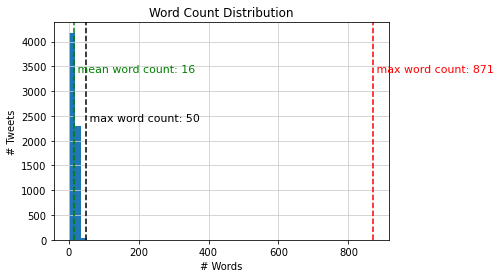

In [157]:
min_word_count, mean_word_count, max_word_count = print_word_count_distribution(
    development_data_df['lengths'], proposed_max_sequence_length = max_sequence_length, caption_vertical_offset = -1000
)

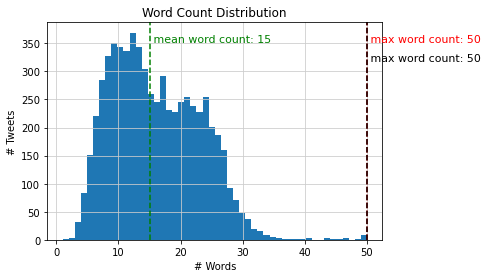

In [158]:
min_word_count, mean_word_count, max_word_count = print_word_count_distribution(
    development_data_df['lengths_capped'], proposed_max_sequence_length = max_sequence_length, caption_vertical_offset = -35
)

In [186]:
distributions_holdout = {
    'Label': ['fake', 'real'],
    #'Index': [0, 1],
    'Count (n)': [
        len(holdout_data_df.loc[holdout_data_df['label'] == 'fake']),
        len(holdout_data_df.loc[holdout_data_df['label'] == 'real'])
    ],
    'Percent (%)': [
        np.round(len(holdout_data_df.loc[holdout_data_df['label'] == 'fake']) / holdout_row_count, 2) * 100.0,
        np.round(len(holdout_data_df.loc[holdout_data_df['label'] == 'real']) / holdout_row_count, 2) * 100.0
    ]
}
pd.DataFrame(data=distributions_holdout)

,Label,Count (n),Percent (%)
0,fake,992,48.0
1,real,1063,52.0


#### Training, Validation, Testing

In [23]:
# identify target variable
target_variable = 'target'
target_text_factor = 'tweet'
target_text_factor_2 = 'tweet_adj'

In [24]:
# identify candidate variables for modeling later
candidate_variables = [target_text_factor, target_text_factor_2]

In [25]:
all_variables = candidate_variables + [target_variable]

In [26]:
# let the candidate variables be represented as X (a matrix) and let the target variable be 
#  represented as y (a vector)
X = development_data_df[candidate_variables]
y = development_data_df[target_variable]

validation_size = 0.10

# split data into a training set and a test set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = validation_size, random_state = 1111)

In [27]:
X_test = holdout_data_df[candidate_variables]
y_test = holdout_data_df[target_variable]

In [184]:
development_data_df[['tweet', 'label']].head(10)

,tweet,label
0,"""[T]he label of the popular Lysol already show...",fake
1,There were more deaths on the roads of France ...,fake
2,250 new cases of #COVID19Nigeria; Plateau-69 F...,real
3,@XanderArmstrong Why was chloroquine described...,fake
4,Our new Can Compare 'College' tags make it eas...,real
5,There is a higher risk of severe #COVID19 for ...,real
6,The President of the United States of America ...,fake
7,Don't give up on patients who still report sym...,real
8,Here's a map of the number of new cases report...,real
9,Holy Qur'an was banned in China now ban\nHas b...,fake


In [185]:
development_data_df[['tweet', 'label', 'lengths', 'target']].head(10)

,tweet,label,lengths,target
0,"""[T]he label of the popular Lysol already show...",fake,12,1
1,There were more deaths on the roads of France ...,fake,6,1
2,250 new cases of #COVID19Nigeria; Plateau-69 F...,real,27,0
3,@XanderArmstrong Why was chloroquine described...,fake,17,1
4,Our new Can Compare 'College' tags make it eas...,real,20,0
5,There is a higher risk of severe #COVID19 for ...,real,13,0
6,The President of the United States of America ...,fake,9,1
7,Don't give up on patients who still report sym...,real,9,0
8,Here's a map of the number of new cases report...,real,12,0
9,Holy Qur'an was banned in China now ban\nHas b...,fake,12,1


<hr/>

### TF IDF Vectorization

In [28]:
%%time

unique_features_list, doc_term_matrix, vocabulary_index, vectorizer = preprocessor.get_doc_term_matrix(
    X_train[target_text_factor].values,
    ngram_range = (1, 3),
    min_max_range = (.01, .8)# (.10, .60)
)

CPU times: user 3.78 s, sys: 19.6 ms, total: 3.79 s
Wall time: 3.8 s


In [29]:
len(unique_features_list)

258

In [31]:
X_train_adj = doc_term_matrix.toarray()

X_valid_adj = vectorizer.transform(X_valid[target_text_factor].values).toarray()
X_test_adj = vectorizer.transform(X_test[target_text_factor].values).toarray()

In [32]:
X_train_adj.shape == doc_term_matrix.shape

True

In [33]:
X_train_adj = pd.DataFrame(data=X_train_adj, columns=unique_features_list)
X_train_adj.head(4)

,across,active,active cases,also,amp,announced,april,around,auckland,average,...,way,wear,week,weeks,work,world,would,yesterday,york,zealand
0,0.0,0.000000,0.000000,0.267253,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.359118,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.227695,0.238695,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [34]:
X_valid_adj = pd.DataFrame(data=X_valid_adj, columns=unique_features_list)
X_valid_adj.head(4)

,across,active,active cases,also,amp,announced,april,around,auckland,average,...,way,wear,week,weeks,work,world,would,yesterday,york,zealand
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.28566,0.0,0.0,0.0,0.0,0.271902
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.347018,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.298133,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000


In [35]:
X_test_adj = pd.DataFrame(data=X_test_adj, columns=unique_features_list)
X_test_adj.head(4)

,across,active,active cases,also,amp,announced,april,around,auckland,average,...,way,wear,week,weeks,work,world,would,yesterday,york,zealand
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.257283,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.196748,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<hr/>

### Embeddings

##### Global Vectors for Word Representation (GloVe)
https://nlp.stanford.edu/projects/glove/

In [36]:
embedding_dim = 100

special_tokens = ['<PAD>', '<UNK>'] # keep <PAD> first

pretrainedEmbeddingsInfo = PretrainedEmbeddingsInfo(parent_data_dir = 'data')
pretrainedEmbeddingsInfo.load(embedding_dim, special_tokens)

if not pretrainedEmbeddingsInfo.Vocab is None:
    print('Found pretrained embeddings vocabulary')
    print('Size: {:,}'.format(len(pretrainedEmbeddingsInfo.Vocab)))
else:
    print('Missing or invalid pretrained embeddings vocabulary')

if not pretrainedEmbeddingsInfo.Embeddings is None:
    print('Found pretrained embeddings matrix')
    print('Size: {:,} words(s) and {:,} dimensions(s)'.format(pretrainedEmbeddingsInfo.Embeddings.shape[0], pretrainedEmbeddingsInfo.Embeddings.shape[1]))
    print('* There should be {:,} additional vectors to account for \'special_tokens\''.format(len(special_tokens)))
else:
    print('Missing or invalid pretrained embeddings matrix')

Found pretrained embeddings vocabulary
Size: 400,002
Found pretrained embeddings matrix
Size: 400,002 words(s) and 100 dimensions(s)
* There should be 2 additional vectors to account for 'special_tokens'


<hr/>

### Modeling - Baselines

In [37]:
cross_validation = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 100)

#### TF-IDF + Logistic Regression with Grid Search (for Hyperparameter Tuning)

In [170]:
def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    """Visualize coefficients of a linear model.
    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.
    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.
    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ['#aa0000' if c < 0 else '#00aa00'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    #plt.xticks(np.arange(1, 1 + 2 * n_top_features),
    plt.xticks(np.arange(0, 0 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=90, #60,
               ha="right")
    plt.title("Top {:,} features [Logistic Regression]".format(n_top_features))
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Features")

In [171]:
lr, lr_best_score, lr_best_params_ = get_log_regression_model(X_train_adj, y_train, cross_validation)

In [172]:
print("Logistic Regression best mean cross-validation score: {:.3f}".format(lr_best_score))
print("Logistic Regression best parameters: {}".format(lr_best_params_))

Logistic Regression best mean cross-validation score: 0.962
Logistic Regression best parameters: {'C': 1, 'fit_intercept': True}


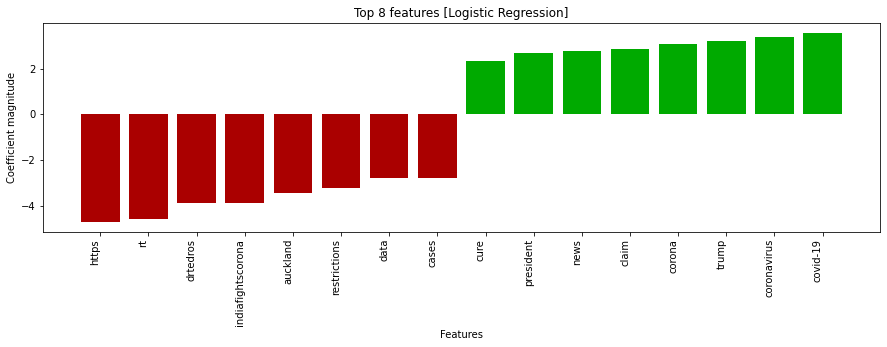

In [176]:
#visualize_coefficients(lr.coef_[0], unique_features_list, n_top_features = 15)
visualize_coefficients(lr.coef_[0], unique_features_list, n_top_features = 8)

In [44]:
prec, recall, f1, support = precision_recall_fscore_support(y_train, lr.predict(X_train_adj), average='weighted') # pos_label = 1, average = 'binary', labels=['negative', 'positive']
print('precision: {} | recall: {} | f1: {} | support: {}'.format(prec, recall, f1, support))

accur = accuracy_score(y_train, lr.predict(X_train_adj))
print('accur: {}'.format(accur))

precision: 0.9099643347595567 | recall: 0.9099760847283909 | f1: 0.9099625169398579 | support: None
accur: 0.9099760847283909


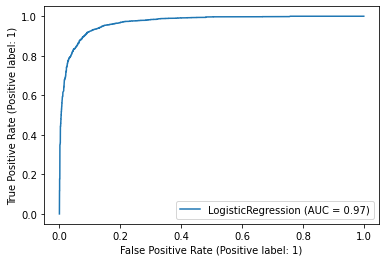

In [45]:
plot_roc_curve(lr, X_train_adj, y_train)
plt.show()

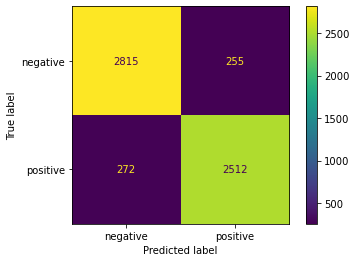

In [46]:
plot_confusion_matrix(lr, X_train_adj, y_train, display_labels=['negative', 'positive'])  
plt.show() 

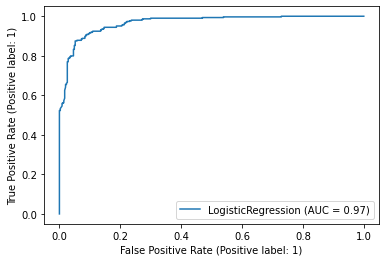

In [47]:
plot_roc_curve(lr, X_valid_adj, y_valid)
plt.show()

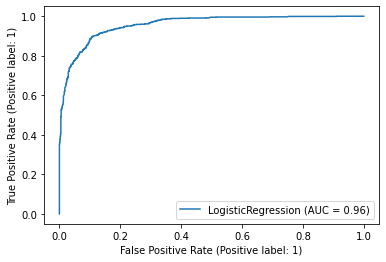

In [189]:
plot_roc_curve(lr, X_test_adj, y_test)
plt.show()

#### TF-IDF + Random Forest with Grid Search (for Hyperparameter Tuning)

In [48]:
ranForest, ranForest_best_score, ranForest_best_params = get_random_forest_model(X_train_adj, y_train, cross_validation)

In [49]:
print("Random Forest best mean cross-validation score: {:.3f}".format(ranForest_best_score))
print("Random Forest best parameters: {}".format(ranForest_best_params))

Random Forest best mean cross-validation score: 0.970
Random Forest best parameters: {'max_depth': None, 'n_estimators': 150}


In [50]:
prec, recall, f1, support = precision_recall_fscore_support(y_train, ranForest.predict(X_train_adj), average='weighted') # pos_label = 1, average = 'binary', labels=['negative', 'positive']
print('precision: {} | recall: {} | f1: {} | support: {}'.format(prec, recall, f1, support))

accur = accuracy_score(y_train, ranForest.predict(X_train_adj))
print('accur: {}'.format(accur))

precision: 0.9928351584945367 | recall: 0.9928254185172531 | f1: 0.992826108400225 | support: None
accur: 0.9928254185172531


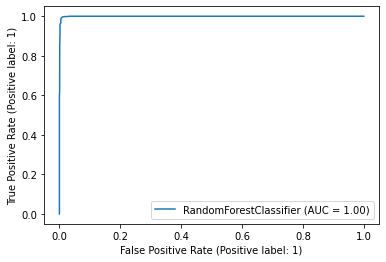

In [51]:
plot_roc_curve(ranForest, X_train_adj, y_train)
plt.show()

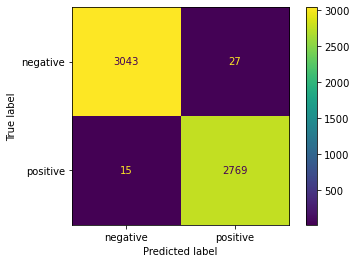

In [52]:
plot_confusion_matrix(ranForest, X_train_adj, y_train, display_labels=['negative', 'positive'])  
plt.show() 

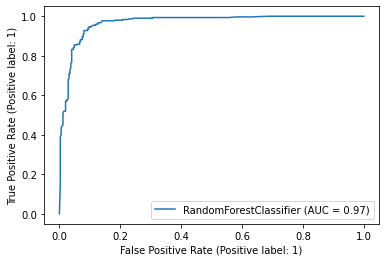

In [53]:
plot_roc_curve(ranForest, X_valid_adj, y_valid)
plt.show()

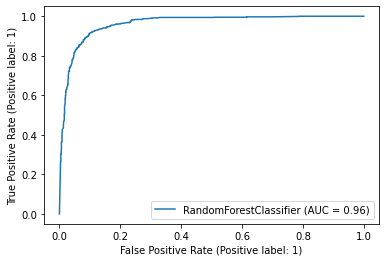

In [191]:
plot_roc_curve(ranForest, X_test_adj, y_test)
plt.show()

#### TF-IDF + XGBoost w/Scikit-Learn Wrapper interface

###### https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [54]:
xgbClassifier, xgbClassifier_best_score, xgbClassifier_best_params = get_xgboost_model(X_train_adj, y_train, cross_validation)

In [55]:
print("XGBoost best mean cross-validation score: {:.3f}".format(xgbClassifier_best_score))
print("XGBoost best parameters: {}".format(xgbClassifier_best_params))

XGBoost best mean cross-validation score: 0.974
XGBoost best parameters: {'n_estimators': 150, 'n_jobs': 1, 'use_label_encoder': False, 'verbosity': 0}


In [56]:
prec, recall, f1, support = precision_recall_fscore_support(y_train, xgbClassifier.predict(X_train_adj), average='weighted') # pos_label = 1, average = 'binary', labels=['negative', 'positive']
print('precision: {} | recall: {} | f1: {} | support: {}'.format(prec, recall, f1, support))

accur = accuracy_score(y_train, xgbClassifier.predict(X_train_adj))
print('accur: {}'.format(accur))

precision: 0.9728583394466209 | recall: 0.9728390843867442 | f1: 0.9728423131130736 | support: None
accur: 0.9728390843867442


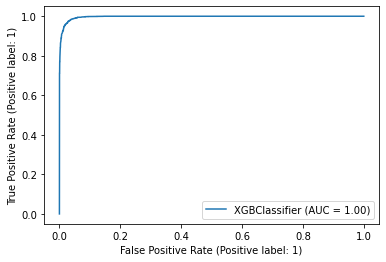

In [57]:
plot_roc_curve(xgbClassifier, X_train_adj, y_train)
plt.show()

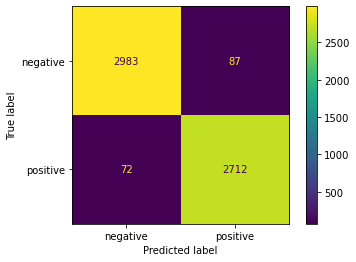

In [58]:
plot_confusion_matrix(xgbClassifier, X_train_adj, y_train, display_labels=['negative', 'positive'])  
plt.show()

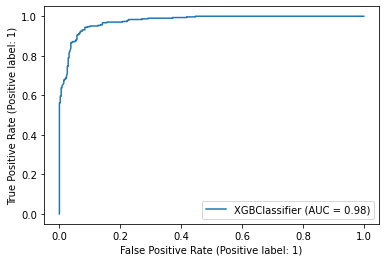

In [59]:
plot_roc_curve(xgbClassifier, X_valid_adj, y_valid)
plt.show()

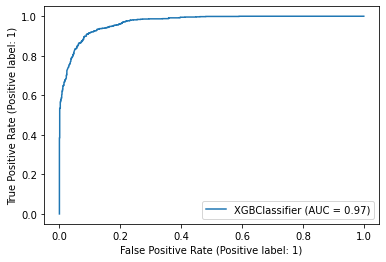

In [192]:
plot_roc_curve(xgbClassifier, X_test_adj, y_test)
plt.show()

#### Convolutional Neural Network (CNN) - PyTorch

##### Grid Search

In [72]:
# %%time

# epochs = 10 #40 #10
# batch_size = 50

# # developer_params_grid_search = {
# #     'optimizer_type': ['RMSprop'], #['RMSprop', 'Adam', 'SGD'],
# #     'use_scheduler': [True], #, False],
# #     'learning_rate': [0.001, 0.01], #[0.001, 0.01, 0.1],
# #     'l2_penalty': [0],
# #     'amsgrad': [False],
# #     'beta_1': [0.05, 0.1, 0.5], #[0.01, 0.05, 0.1, 0.5],
# #     'beta_2': [0.55], #[0.1, 0.5, 0.55],
# #     'decay_rate': [0.01, 0.05],
# #     'alpha/rho': [ 0.9], #[0.1, 0.5, 0.90],
# #     'momentum': [0.0],
# #     'centered': [False]
# # }

# developer_params_grid_search = {
#     'optimizer_type': ['RMSprop'],
#     'use_scheduler': [True],
#     'learning_rate': [0.001],
#     'l2_penalty': [0],
#     'amsgrad': [False],
#     'beta_1': [0.1],
#     'beta_2': [0.55],
#     'decay_rate': [0.05],
#     'alpha/rho': [0.9],
#     'momentum': [0.0],
#     'centered': [False]
# }

# results_list = get_trained_classifier_grid_search(
#     embed_object = pretrainedEmbeddingsInfo,
#     target_text_column = target_text_factor,
#     X_train = X_train,
#     y_train = y_train,
#     X_valid = X_valid,
#     y_valid = y_valid,
#     X_test = X_test,
#     y_test = y_test,
#     epochs = epochs,
#     max_sequence_length = max_sequence_length,
#     test_size = validation_size,
#     batch_size = batch_size,
#     developer_params_grid_search = developer_params_grid_search,
#     stop_words = preprocessor.get_stop_words()
# )

In [73]:
#results_list[0]

In [74]:
# result_dict = results_list[0][1] # tuple(0 = validation_accuracy, 1 = dict of model details)

# classifier = result_dict['classifier']
# epoch_curve = result_dict['epoch_curve']
# training_loss_curve = result_dict['training_loss_curve']
# validation_loss_curve = result_dict['validation_loss_curve']
# training_accuracy = result_dict['training_accuracy']
# validation_accuracy = result_dict['validation_accuracy']
# testing_accuracy = result_dict['testing_accuracy']
# model_and_training_params = result_dict['developer_params']

# print('Training Accuracy: {:3.5}'.format(training_accuracy))
# print('Validation Accuracy: {:3.5}'.format(validation_accuracy))
# print('Testing Accuracy: {:3.5}'.format(testing_accuracy))
# print('Model and Training Parameters: {}'.format(model_and_training_params))

In [75]:
# learning_loss_curve(x = epoch_curve, series1 = training_loss_curve, series2 = validation_loss_curve, caption = ' (CNN PyTorch)')

In [66]:
epochs = 10 #30 (92%)
batch_size = 50

developer_params = {
    'optimizer_type': 'RMSprop', #'Adam',
    'use_scheduler': True, #False,
    'learning_rate': 0.001,
    'l2_penalty': 0,
    'amsgrad': False,
    'beta_1': 0.1,
    'beta_2': 0.55,
    'decay_rate': 0.05,
    'alpha/rho': 0.9,
    'momentum': 0.0,
    'centered': False
}

In [67]:
classifier, epoch_curve, training_loss_curve, validation_loss_curve = get_trained_classifier(
    pretrainedEmbeddingsInfo,
    target_text_factor,
    X_train,
    y_train,
    X_valid,
    y_valid,
    epochs,
    max_sequence_length,
    test_size = validation_size,
    batch_size = batch_size,
    developer_params = developer_params,
    stop_words = preprocessor.get_stop_words()
)

 89%|████████████████████████████████████▍    | 105/118 [00:21<00:04,  3.01it/s]

Epoch: 1 of 10 | Step: 105 | Loss: 0.2388 | Loss (Validation): 0.2567
Current: 0.256720 | Best: 2.000000
Checkpoint saved to: models_training/checkpoint_v1_0_0.step105.tar
New best model saved to: models_training/best_v1_0_0.tar
Best model path: models_training/best_v1_0_0.tar


 89%|████████████████████████████████████▍    | 105/118 [00:20<00:04,  3.01it/s]

Epoch: 2 of 10 | Step: 105 | Loss: 0.2980 | Loss (Validation): 0.1671
Current: 0.167147 | Best: 0.256720
Checkpoint saved to: models_training/checkpoint_v1_0_0.step105.tar
New best model saved to: models_training/best_v1_0_0.tar
Best model path: models_training/best_v1_0_0.tar


 89%|████████████████████████████████████▍    | 105/118 [00:20<00:04,  3.05it/s]

Epoch: 3 of 10 | Step: 105 | Loss: 0.0522 | Loss (Validation): 0.1343
Current: 0.134253 | Best: 0.167147
Checkpoint saved to: models_training/checkpoint_v1_0_0.step105.tar
New best model saved to: models_training/best_v1_0_0.tar
Best model path: models_training/best_v1_0_0.tar


 89%|████████████████████████████████████▍    | 105/118 [00:20<00:04,  3.04it/s]

Epoch: 4 of 10 | Step: 105 | Loss: 0.0488 | Loss (Validation): 0.1174
Current: 0.117375 | Best: 0.134253
Checkpoint saved to: models_training/checkpoint_v1_0_0.step105.tar
New best model saved to: models_training/best_v1_0_0.tar
Best model path: models_training/best_v1_0_0.tar


 89%|████████████████████████████████████▍    | 105/118 [00:20<00:04,  3.06it/s]

Epoch: 5 of 10 | Step: 105 | Loss: 0.0525 | Loss (Validation): 0.1088
Current: 0.108799 | Best: 0.117375
Checkpoint saved to: models_training/checkpoint_v1_0_0.step105.tar
New best model saved to: models_training/best_v1_0_0.tar
Best model path: models_training/best_v1_0_0.tar


 89%|████████████████████████████████████▍    | 105/118 [00:20<00:04,  3.01it/s]

Epoch: 6 of 10 | Step: 105 | Loss: 0.0683 | Loss (Validation): 0.1067
Current: 0.106718 | Best: 0.108799
Checkpoint saved to: models_training/checkpoint_v1_0_0.step105.tar
New best model saved to: models_training/best_v1_0_0.tar
Best model path: models_training/best_v1_0_0.tar


 89%|████████████████████████████████████▍    | 105/118 [00:42<00:04,  3.08it/s]

Epoch: 7 of 10 | Step: 105 | Loss: 0.0625 | Loss (Validation): 0.1076
Current: 0.107627 | Best: 0.106718
Checkpoint saved to: models_training/checkpoint_v1_0_0.step105.tar
Best model path: models_training/best_v1_0_0.tar


 89%|████████████████████████████████████▍    | 105/118 [00:21<00:04,  3.04it/s]

Epoch: 8 of 10 | Step: 105 | Loss: 0.0281 | Loss (Validation): 0.1003
Current: 0.100329 | Best: 0.106718
Checkpoint saved to: models_training/checkpoint_v1_0_0.step105.tar
New best model saved to: models_training/best_v1_0_0.tar
Best model path: models_training/best_v1_0_0.tar


 89%|████████████████████████████████████▍    | 105/118 [00:21<00:04,  3.10it/s]

Epoch: 9 of 10 | Step: 105 | Loss: 0.0209 | Loss (Validation): 0.1195
Current: 0.119508 | Best: 0.100329
Checkpoint saved to: models_training/checkpoint_v1_0_0.step105.tar
Best model path: models_training/best_v1_0_0.tar


 89%|████████████████████████████████████▍    | 105/118 [00:21<00:04,  3.12it/s]

Epoch: 10 of 10 | Step: 105 | Loss: 0.0086 | Loss (Validation): 0.1183
Current: 0.118301 | Best: 0.100329
Checkpoint saved to: models_training/checkpoint_v1_0_0.step105.tar
Best model path: models_training/best_v1_0_0.tar


100%|█████████████████████████████████████████| 118/118 [00:23<00:00,  5.01it/s]


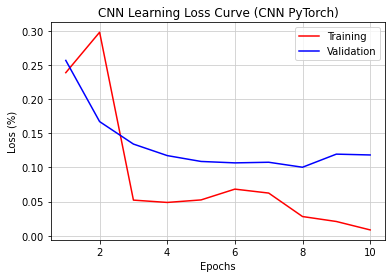

In [76]:
learning_loss_curve(x = epoch_curve, series1 = training_loss_curve, series2 = validation_loss_curve, caption = ' (CNN PyTorch)')

In [77]:
classifier_results = classifier.predict_multiple(X_train[target_text_factor].values)
prec, recall, f1, support = precision_recall_fscore_support(y_train, classifier_results, average='weighted') # pos_label = 1, average = 'binary', labels=['negative', 'positive']
print('precision: {} | recall: {} | f1: {} | support: {}'.format(prec, recall, f1, support))

accur = accuracy_score(y_train, classifier_results)
print('accur: {}'.format(accur))

precision: 0.9981210326620065 | recall: 0.9981209429449949 | f1: 0.9981209586092582 | support: None
accur: 0.9981209429449949


In [78]:
classifier_results = classifier.predict_multiple(X_test[target_text_factor].values)

In [79]:
prec, recall, f1, support = precision_recall_fscore_support(y_test, classifier_results, average='weighted') # pos_label = 1, average = 'binary', labels=['negative', 'positive']
print('precision: {} | recall: {} | f1: {} | support: {}'.format(prec, recall, f1, support))

accur = accuracy_score(y_test, classifier_results)
print('accur: {}'.format(accur))

precision: 0.9610723136947834 | recall: 0.9610705596107056 | f1: 0.9610677904088 | support: None
accur: 0.9610705596107056


#### Bi-LSTM

In [96]:
developer_params_bilstm = {
    'optimizer_type': 'RMSprop', #'Adam',
    'use_scheduler': True, #False,
    'learning_rate': 0.001,
    'l2_penalty': 0,
    'amsgrad': False,
    'beta_1': 0.1,
    'beta_2': 0.55,
    'decay_rate': 0.05,
    'alpha/rho': 0.9,
    'momentum': 0.0,
    'centered': False
}

In [97]:
bilstm_classifier, epoch_curve, training_loss_curve, validation_loss_curve = get_trained_bilstm_classifier(
    pretrainedEmbeddingsInfo,
    target_text_factor,
    X_train,
    y_train,
    X_valid,
    y_valid,
    epochs,
    max_sequence_length,
    test_size = validation_size,
    batch_size = batch_size,
    hidden_size = 128,
    developer_params = developer_params_bilstm,
    stop_words = preprocessor.get_stop_words()
)

 89%|████████████████████████████████████▍    | 105/118 [00:27<00:06,  2.06it/s]

Epoch: 1 of 10 | Step: 105 | Loss: 0.3561 | Loss (Validation): 0.2620
Current: 0.261969 | Best: 2.000000
Checkpoint saved to: models_training/checkpoint_v1_0_0.step105.tar
New best model saved to: models_training/best_v1_0_0.tar
Best model path: models_training/best_v1_0_0.tar


 89%|████████████████████████████████████▍    | 105/118 [00:27<00:06,  2.04it/s]

Epoch: 2 of 10 | Step: 105 | Loss: 0.1795 | Loss (Validation): 0.2046
Current: 0.204561 | Best: 0.261969
Checkpoint saved to: models_training/checkpoint_v1_0_0.step105.tar
New best model saved to: models_training/best_v1_0_0.tar
Best model path: models_training/best_v1_0_0.tar


 89%|████████████████████████████████████▍    | 105/118 [00:27<00:06,  2.07it/s]

Epoch: 3 of 10 | Step: 105 | Loss: 0.0756 | Loss (Validation): 0.1458
Current: 0.145847 | Best: 0.204561
Checkpoint saved to: models_training/checkpoint_v1_0_0.step105.tar
New best model saved to: models_training/best_v1_0_0.tar
Best model path: models_training/best_v1_0_0.tar


 89%|████████████████████████████████████▍    | 105/118 [00:27<00:06,  2.08it/s]

Epoch: 4 of 10 | Step: 105 | Loss: 0.0821 | Loss (Validation): 0.1211
Current: 0.121139 | Best: 0.145847
Checkpoint saved to: models_training/checkpoint_v1_0_0.step105.tar
New best model saved to: models_training/best_v1_0_0.tar
Best model path: models_training/best_v1_0_0.tar


 89%|████████████████████████████████████▍    | 105/118 [00:27<00:06,  2.05it/s]

Epoch: 5 of 10 | Step: 105 | Loss: 0.2033 | Loss (Validation): 0.1072
Current: 0.107212 | Best: 0.121139
Checkpoint saved to: models_training/checkpoint_v1_0_0.step105.tar
New best model saved to: models_training/best_v1_0_0.tar
Best model path: models_training/best_v1_0_0.tar


 89%|████████████████████████████████████▍    | 105/118 [00:27<00:06,  2.11it/s]

Epoch: 6 of 10 | Step: 105 | Loss: 0.0168 | Loss (Validation): 0.1263
Current: 0.126275 | Best: 0.107212
Checkpoint saved to: models_training/checkpoint_v1_0_0.step105.tar
Best model path: models_training/best_v1_0_0.tar


 89%|████████████████████████████████████▍    | 105/118 [00:27<00:06,  2.10it/s]

Epoch: 7 of 10 | Step: 105 | Loss: 0.0295 | Loss (Validation): 0.1653
Current: 0.165333 | Best: 0.107212
Checkpoint saved to: models_training/checkpoint_v1_0_0.step105.tar
Best model path: models_training/best_v1_0_0.tar


 89%|████████████████████████████████████▍    | 105/118 [00:28<00:06,  2.08it/s]

Epoch: 8 of 10 | Step: 105 | Loss: 0.0211 | Loss (Validation): 0.1379
Current: 0.137860 | Best: 0.107212
Checkpoint saved to: models_training/checkpoint_v1_0_0.step105.tar
Best model path: models_training/best_v1_0_0.tar


 89%|████████████████████████████████████▍    | 105/118 [00:28<00:06,  2.06it/s]

Epoch: 9 of 10 | Step: 105 | Loss: 0.0071 | Loss (Validation): 0.1447
Current: 0.144683 | Best: 0.107212
Checkpoint saved to: models_training/checkpoint_v1_0_0.step105.tar
Best model path: models_training/best_v1_0_0.tar


 89%|████████████████████████████████████▍    | 105/118 [00:28<00:06,  2.11it/s]

Epoch: 10 of 10 | Step: 105 | Loss: 0.0041 | Loss (Validation): 0.1638
Current: 0.163845 | Best: 0.107212
Checkpoint saved to: models_training/checkpoint_v1_0_0.step105.tar
Best model path: models_training/best_v1_0_0.tar


100%|█████████████████████████████████████████| 118/118 [00:31<00:00,  3.77it/s]


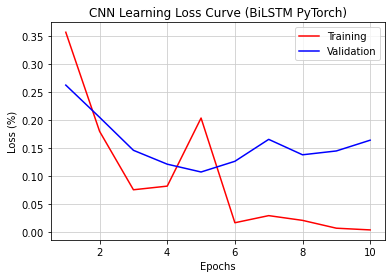

In [98]:
learning_loss_curve(x = epoch_curve, series1 = training_loss_curve, series2 = validation_loss_curve, caption = ' (BiLSTM PyTorch)')

In [99]:
bilstm_classifier_results = bilstm_classifier.predict_multiple(X_train[target_text_factor].values, verbose = True)
prec, recall, f1, support = precision_recall_fscore_support(y_train, bilstm_classifier_results, average='weighted') # pos_label = 1, average = 'binary', labels=['negative', 'positive']
print('precision: {} | recall: {} | f1: {} | support: {}'.format(prec, recall, f1, support))

accur = accuracy_score(y_train, bilstm_classifier_results)
print('accur: {}'.format(accur))

precision: 0.9845488501698424 | recall: 0.9844550734540485 | f1: 0.9844486358909493 | support: None
accur: 0.9844550734540485


In [100]:
bilstm_classifier_results = bilstm_classifier.predict_multiple(X_test[target_text_factor].values, verbose = True)
prec, recall, f1, support = precision_recall_fscore_support(y_test, bilstm_classifier_results, average='weighted') # pos_label = 1, average = 'binary', labels=['negative', 'positive']
print('precision: {} | recall: {} | f1: {} | support: {}'.format(prec, recall, f1, support))

accur = accuracy_score(y_test, bilstm_classifier_results)
print('accur: {}'.format(accur))

precision: 0.9516752332948298 | recall: 0.9513381995133819 | f1: 0.9513032003642425 | support: None
accur: 0.9513381995133819


#### BERT

In [101]:
developer_params_bert = {
    'optimizer_type': 'RMSprop', #'Adam',
    'use_scheduler': True, #False,
    'learning_rate': 0.001,
    'l2_penalty': 0,
    'amsgrad': False,
    'beta_1': 0.1,
    'beta_2': 0.55,
    'decay_rate': 0.05,
    'alpha/rho': 0.9,
    'momentum': 0.0,
    'centered': False
}

# bert_weights_name = 'bert-base-uncased' #'bert-base-cased'

# bert_classifier, bert_tokenizer, epoch_curve, training_loss_curve, validation_loss_curve = get_trained_bert_classifier(
#     target_text_column = target_text_factor,
#     X_train = X_train, #.iloc[0:100],
#     y_train = y_train, #.iloc[0:100],
#     X_valid = X_valid, #.iloc[0:100],
#     y_valid = y_valid, #.iloc[0:100],
#     epochs = epochs,
#     max_sequence_length = max_sequence_length,
#     batch_size = batch_size,
#     developer_params = developer_params_bert,
#     bert_weights_name = bert_weights_name
# )

In [102]:
# X_test_bert_ds = BertMisinfoDataset(
#     tokenizer = bert_tokenizer,
#     data_X_df = X_test,
#     data_y_df = y_test,
#     target_text_factor = target_text_factor,
#     max_sequence_length = max_sequence_length
# )

In [103]:
# bert_classifier_results = bert_classifier.predict_multiple(X_test[target_text_factor].values) #iloc[0:100]

#### RoBERTa

In [ ]:
epochs_roberta = 3 #10
batch_size_roberta = 50

developer_params_roberta = {
    'optimizer_type': 'RMSprop', #'Adam',
    'use_scheduler': True, #False,
    'learning_rate': 0.001,
    'l2_penalty': 0,
    'amsgrad': False,
    'beta_1': 0.1,
    'beta_2': 0.55,
    'decay_rate': 0.05,
    'alpha/rho': 0.9,
    'momentum': 0.0,
    'centered': False
}

roberta_weights_name = 'roberta-base'

X_train_sample = X_train.sample(n = 1500, random_state = 1111)
y_train_sample = y_train[X_train_sample.index]

X_valid_sample = X_valid.sample(n = 300, random_state = 1234)
y_valid_sample = y_valid[X_valid_sample.index]

roberta_classifier, roberta_tokenizer, epoch_curve, training_loss_curve, validation_loss_curve = get_trained_roberta_classifier(
    target_text_factor = target_text_factor,
    X_train = X_train_sample,
    y_train = y_train_sample,
    X_valid = X_valid_sample,
    y_valid = y_valid_sample,
    epochs = epochs_roberta,
    max_sequence_length = max_sequence_length,
    batch_size = batch_size_roberta,
    developer_params = developer_params_roberta,
    bert_weights_name= roberta_weights_name
)

<hr/>

### Performance and Assessment

#### TF-IDF + Logistic Regression with Grid Search (for Hyperparameter Tuning)

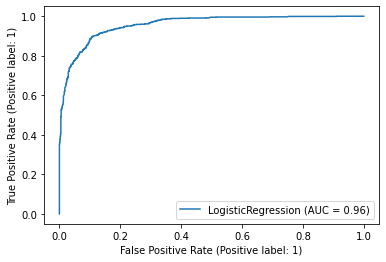

In [105]:
plot_roc_curve(lr, X_test_adj, y_test)
plt.show()

In [106]:
prec, recall, f1, support = precision_recall_fscore_support(y_test, lr.predict(X_test_adj), average='weighted') # pos_label = 1, average = 'binary', labels=['negative', 'positive']
print('precision: {} | recall: {} | f1: {} | support: {}'.format(prec, recall, f1, support))

accur = accuracy_score(y_test, lr.predict(X_test_adj))
print('accur: {}'.format(accur))

precision: 0.8890858284991477 | recall: 0.8890510948905109 | f1: 0.8890144580768632 | support: None
accur: 0.8890510948905109


#### TF-IDF + Random Forest with Grid Search (for Hyperparameter Tuning)

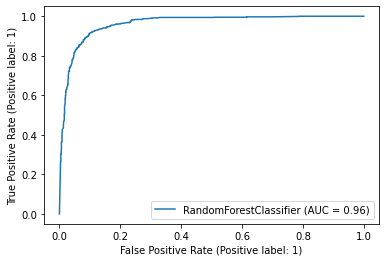

In [107]:
plot_roc_curve(ranForest, X_test_adj, y_test)
plt.show()

In [108]:
prec, recall, f1, support = precision_recall_fscore_support(y_test, ranForest.predict(X_test_adj), average='weighted') # pos_label = 1, average = 'binary', labels=['negative', 'positive']
print('precision: {} | recall: {} | f1: {} | support: {}'.format(prec, recall, f1, support))

accur = accuracy_score(y_test, ranForest.predict(X_test_adj))
print('accur: {}'.format(accur))

precision: 0.9020791076201569 | recall: 0.9017031630170317 | f1: 0.9016132585688968 | support: None
accur: 0.9017031630170317


#### TF-IDF + XGBoost w/Scikit-Learn Wrapper interface

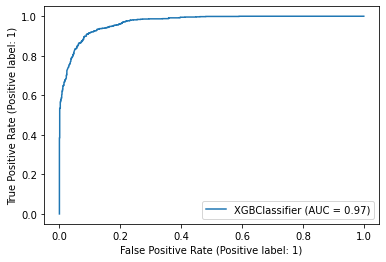

In [109]:
plot_roc_curve(xgbClassifier, X_test_adj, y_test)
plt.show()

In [110]:
prec, recall, f1, support = precision_recall_fscore_support(y_test, xgbClassifier.predict(X_test_adj), average='weighted') # pos_label = 1, average = 'binary', labels=['negative', 'positive']
print('precision: {} | recall: {} | f1: {} | support: {}'.format(prec, recall, f1, support))

accur = accuracy_score(y_test, xgbClassifier.predict(X_test_adj))
print('accur: {}'.format(accur))

precision: 0.9075501068146947 | recall: 0.9075425790754258 | f1: 0.907524817626271 | support: None
accur: 0.9075425790754258


#### Convolutional Neural Network (CNN) - PyTorch

In [111]:
classifier_results = classifier.predict_multiple(X_test[target_text_factor].values)

In [112]:
prec, recall, f1, support = precision_recall_fscore_support(y_test, classifier_results, average='weighted') # pos_label = 1, average = 'binary', labels=['negative', 'positive']
print('precision: {} | recall: {} | f1: {} | support: {}'.format(prec, recall, f1, support))

accur = accuracy_score(y_test, classifier_results)
print('accur: {}'.format(accur))

precision: 0.9610723136947834 | recall: 0.9610705596107056 | f1: 0.9610677904088 | support: None
accur: 0.9610705596107056


#### Bi-LSTM

In [113]:
bilstm_classifier_results = bilstm_classifier.predict_multiple(X_test[target_text_factor].values)

In [114]:
prec, recall, f1, support = precision_recall_fscore_support(y_test, bilstm_classifier_results, average='weighted') # pos_label = 1, average = 'binary', labels=['negative', 'positive']
print('precision: {} | recall: {} | f1: {} | support: {}'.format(prec, recall, f1, support))

accur = accuracy_score(y_test, bilstm_classifier_results)
print('accur: {}'.format(accur))

precision: 0.9516752332948298 | recall: 0.9513381995133819 | f1: 0.9513032003642425 | support: None
accur: 0.9513381995133819


#### BERT

#### RoBERTa

<hr/>